<a href="https://colab.research.google.com/github/Nithinps021/DeepLearning/blob/master/hands__on_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tarfile
from six.moves import urllib

In [2]:
DOWNLOAD_ROOT="https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH='datasets/housing'
HOUSING_URL=DOWNLOAD_ROOT + HOUSING_PATH + '/housing.tgz'

def fetch_data(housing_url=HOUSING_URL,housing_path=HOUSING_PATH):
  if not os.path.isdir(housing_path):
    os.makedirs(housing_path)
  tgz_path=os.path.join(housing_path,'housing.tgz')
  urllib.request.urlretrieve(housing_url,tgz_path)
  housing_tgz=tarfile.open(tgz_path)
  housing_tgz.extractall(path='sample_data/'+housing_path)
  housing_tgz.close()
  
fetch_data()


In [3]:
import pandas as pd

def loadHousingData(housing_path='sample_data/'+HOUSING_PATH):
  path_housing_csv=os.path.join(housing_path,'housing.csv')
  return pd.read_csv(path_housing_csv)

In [4]:
housingData=loadHousingData()
housingData['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [5]:
housingData.columns
# housingData["median_income"].value_counts()

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

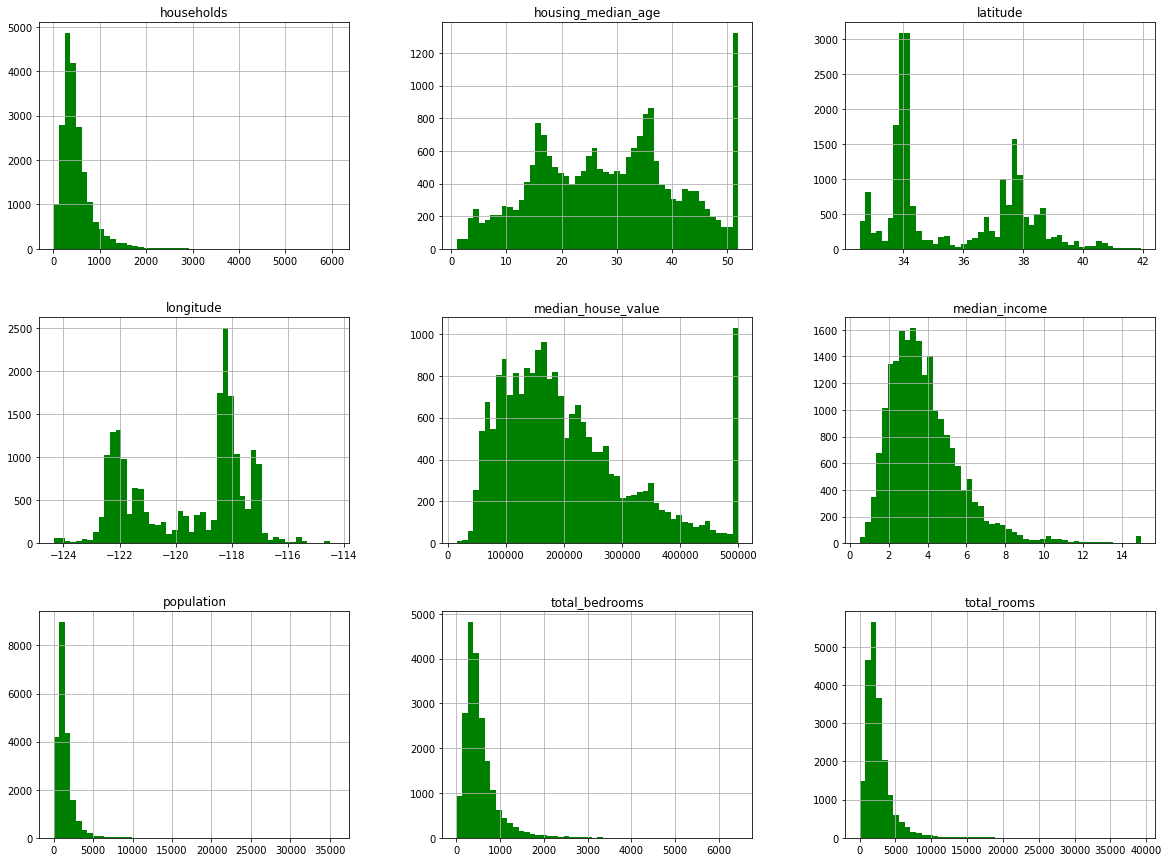

In [6]:
import matplotlib.pyplot as plt

housingData.hist(bins=50,figsize=(20,15),color='green')
plt.show()

In [7]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit


# def shuffle_data(data,testSize):
#   shuffled_indices=np.random.permutation(len(data))
#   test_size=int(len(data)*testSize)
#   test_indices=shuffled_indices[:test_size]
#   train_indices=shuffled_indices[test_size:]
#   return data.iloc[test_indices] ,  data.iloc[train_indices]

# testData,trainData = shuffle_data(housingData,0.2)

# using sklearn train_test_split method

# from sklearn.model_selection import train_test_split
# train_data, test_data=train_test_split(housingData,test_size=0.2,random_state=42)

# print(len(train_data),len(test_data))


# StratifiedShuffleSplit

housingData['income_cat']=np.ceil(housingData['median_income']/1.5)
housingData['income_cat'].where(housingData['income_cat']<5,5.0,inplace=True)
splitData=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for trainIndex,testIndex in splitData.split(housingData,housingData['income_cat']):
  train_data=housingData.iloc[trainIndex]
  test_data=housingData.iloc[testIndex]
for  i in (train_data,test_data):
  i.drop(['income_cat'],axis=1,inplace=True)
housingData=train_data.copy()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


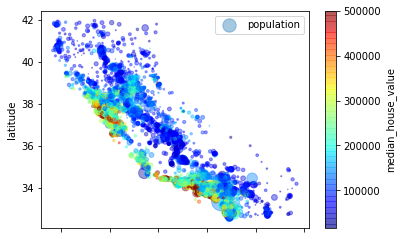

In [8]:

housingData.plot(kind='scatter',x='longitude',y='latitude',alpha=0.4,
                 s=housingData['population']/100,label='population',
                 c='median_house_value',cmap=plt.get_cmap('jet'),colorbar=True
                 )
plt.legend()

In [9]:
# correlation matrix

housingData['rooms_per_house']=housingData['total_rooms']/housingData['households']
housingData['bedrooms_per_room']=housingData['total_bedrooms']/housingData['total_rooms']
housingData['population_per_household']=housingData['population']/housingData['households']
cor_matrix=housingData.corr()
cor_matrix['median_income'].sort_values(ascending=False)

median_income               1.000000
median_house_value          0.687160
rooms_per_house             0.311563
total_rooms                 0.200087
population_per_household    0.021822
households                  0.010781
population                  0.002380
total_bedrooms             -0.009740
longitude                  -0.019583
latitude                   -0.075205
housing_median_age         -0.111360
bedrooms_per_room          -0.624674
Name: median_income, dtype: float64

In [10]:
# separating training data and training labels

housingData=train_data.drop(['median_house_value'],axis=1)
housingLabel=train_data['median_house_value'].copy()
  

In [26]:
# data cleaning
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,LabelBinarizer,StandardScaler

imputer=SimpleImputer(strategy='median')
housing_num=housingData.drop("ocean_proximity",axis=1)
imputer.fit(housing_num)
X=imputer.transform(housing_num)
housing_tr=pd.DataFrame(X,columns=housing_num.columns)
norm=StandardScaler()
normalised=norm.fit_transform(housing_tr)
normalised
# housing_num[number].values


array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.63621141,
        -0.42069842, -0.61493744],
       [-1.17602483,  0.6596948 , -1.1653172 , ..., -0.99833135,
        -1.02222705,  1.33645936],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.43363936,
        -0.0933178 , -0.5320456 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.60790363,
         0.71315642, -0.3167053 ],
       [ 0.78221312, -0.85106801,  0.18664186, ..., -0.05717804,
        -0.37545069,  0.09812139],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.13515931,
         0.3777909 , -0.15779865]])

In [12]:
# text and categorical attributes

housing_cat=housingData['ocean_proximity']

# encoder=LabelEncoder()
# housing_cat_encode=encoder.fit_transform(housing_cat)
# hotEncoder=OneHotEncoder()
# housing_cat_1hot=hotEncoder.fit_transform(housing_cat_encode.reshape(-1,1))
# housing_cat_1hot.toarray()

encoder=LabelBinarizer()
housing_cat_1hot=encoder.fit_transform(housing_cat)
housing_cat_1hot


array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])